# Fake news detector
Classification of Twitter posts regarding whether they are true or false

Importing necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud

Loading datasets and some pre-preprocessing checks

In [2]:
fake_df = pd.read_csv('data/fake_news/Fake.csv')
true_df = pd.read_csv('data/fake_news/True.csv')

true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


We're encoding real news as 0 and fake news as 1 because we're looking
for fake news in fact.

<AxesSubplot:xlabel='subject', ylabel='count'>

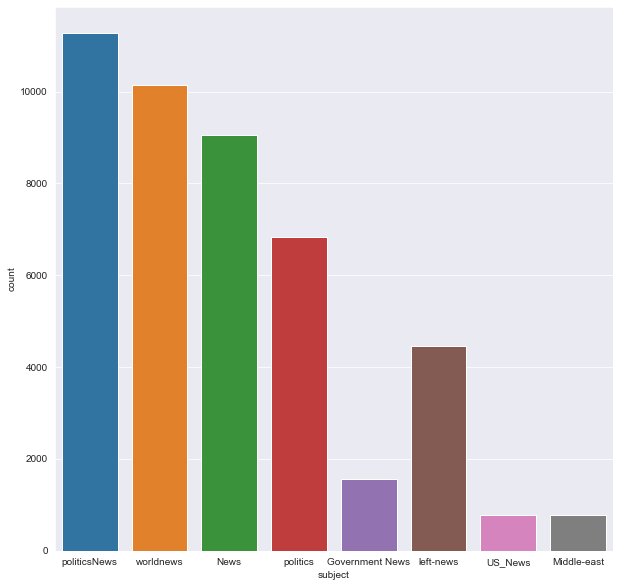

In [3]:
true_df['label'] = 0
fake_df['label'] = 1
news_df = pd.concat([true_df, fake_df])
news_df.reset_index(inplace=True)
plt.figure(figsize=(10, 10))
sns.set_style("darkgrid")
sns.countplot(data=news_df, x='subject')

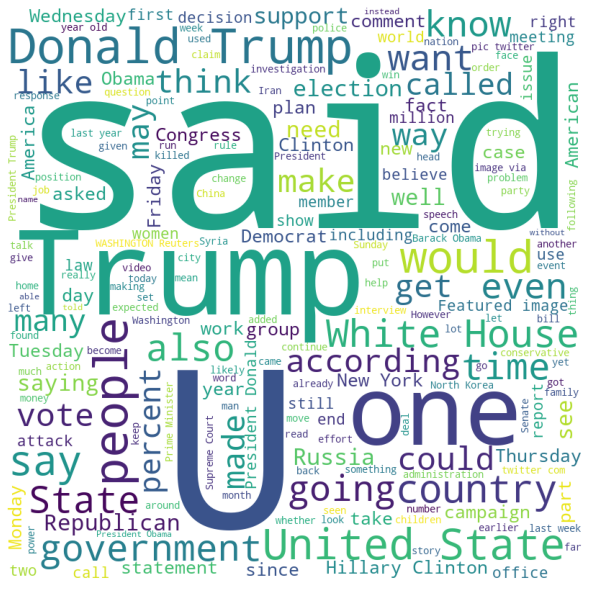

In [4]:
wordcloud = WordCloud(width=800, height=800, background_color='white',
                      stopwords=set(stopwords.words('english')),
                      min_font_size=10).generate(' '.join(news_df['text']))

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [5]:
news_df.drop(columns=['date', 'subject', 'index'], inplace=True)
news_df.describe(include=['O'])

,title,text
count,44898,44898
unique,38729,38646
top,Factbox: Trump fills top jobs for his administ...,
freq,14,627


<AxesSubplot:xlabel='label', ylabel='count'>

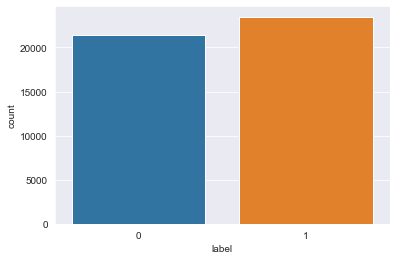

In [6]:
sns.countplot(data=news_df, x='label')

In [7]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   text    44898 non-null  object
 2   label   44898 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [8]:
news_df.isna().sum()

title    0
text     0
label    0
dtype: int64

Moving on to NLP preprocessing. We should concatenate title and text
of articles as there can't be multiple input features. Moreover, we should get rid
of punctuation and stop words.

In [9]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop(columns=['title'], inplace=True)
news_df.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0


In [10]:
X = news_df.drop(columns=['label'])
y = news_df.drop(columns=['text'])
X.head()

,text
0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...


In [11]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [12]:
def tokenize(text):
    return [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]

In [13]:
X['text'] = X['text'].apply(lambda x: str.lower(x))
X['text'] = X['text'].apply(lambda x: tokenize(x))
X.head()

,text
0,"[as, u.s., budget, fight, looms, ,, republican..."
1,"[u.s., military, to, accept, transgender, recr..."
2,"[senior, u.s., republican, senator, :, 'let, m..."
3,"[fbi, russia, probe, helped, by, australian, d..."
4,"[trump, wants, postal, service, to, charge, 'm..."


In [14]:
def remove_punctuation(text):
    return [word for word in text if word.isalnum()]

In [15]:
X['text'] = X['text'].apply(lambda x: remove_punctuation(x))
X.head()

,text
0,"[as, budget, fight, looms, republicans, flip, ..."
1,"[military, to, accept, transgender, recruits, ..."
2,"[senior, republican, senator, mueller, do, his..."
3,"[fbi, russia, probe, helped, by, australian, d..."
4,"[trump, wants, postal, service, to, charge, mo..."


In [16]:
def remove_stopwords(words):
    stopwords_set = set(stopwords.words('english'))
    return [word for word in words if word not in stopwords_set]

In [17]:
X['text'] = X['text'].apply(lambda x: remove_stopwords(x))
X.head()

,text
0,"[budget, fight, looms, republicans, flip, fisc..."
1,"[military, accept, transgender, recruits, mond..."
2,"[senior, republican, senator, mueller, reuters..."
3,"[fbi, russia, probe, helped, australian, diplo..."
4,"[trump, wants, postal, service, charge, amazon..."


Another important step is stemming or lemmatization. I'll use both of these techniques
to see which one will contribute to better performance later on.

In [18]:
def word_lemmatizer(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]


def word_stemmer(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

In [19]:
X_lemmatized = X.copy()
X_lemmatized['text'] = X['text'].apply(lambda x: word_lemmatizer(x))
X_lemmatized.head()

,text
0,"[budget, fight, loom, republican, flip, fiscal..."
1,"[military, accept, transgender, recruit, monda..."
2,"[senior, republican, senator, mueller, reuters..."
3,"[fbi, russia, probe, helped, australian, diplo..."
4,"[trump, want, postal, service, charge, amazon,..."


In [20]:
X_stemmed = X.copy()
X_stemmed['text'] = X_stemmed['text'].apply(lambda x: word_stemmer(x))
X_stemmed.head()

,text
0,"[budget, fight, loom, republican, flip, fiscal..."
1,"[militari, accept, transgend, recruit, monday,..."
2,"[senior, republican, senat, mueller, reuter, s..."
3,"[fbi, russia, probe, help, australian, diploma..."
4,"[trump, want, postal, servic, charg, amazon, r..."


In [21]:
def glue_words_into_text(words):
    return ' '.join(words)

In [22]:
X_lemmatized['text'] = X_lemmatized['text'].apply(lambda x: glue_words_into_text(x))
X_lemmatized.head()

,text
0,budget fight loom republican flip fiscal scrip...
1,military accept transgender recruit monday pen...
2,senior republican senator mueller reuters spec...
3,fbi russia probe helped australian diplomat ny...
4,trump want postal service charge amazon reuter...


In [23]:
X_stemmed['text'] = X_stemmed['text'].apply(lambda x: glue_words_into_text(x))
X_stemmed.head()

,text
0,budget fight loom republican flip fiscal scrip...
1,militari accept transgend recruit monday penta...
2,senior republican senat mueller reuter special...
3,fbi russia probe help australian diplomat nytw...
4,trump want postal servic charg amazon reuter p...


To progress to NLP tasks, we have to vectorize our data. At first, let's
go with lemmatized dataset

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from mlxtend.plotting import plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [25]:
def predict_on_model(model, x_train, y_train, x_test):
    model.fit(x_train, y_train)
    return model.predict(x_test)

In [26]:
def plot_results(y_test, y_pred):
    score = accuracy_score(y_test_lemm, y_pred)
    print('Accuracy: ' + str(score))
    plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred),
                          show_absolute=True,
                          show_normed=True,
                          colorbar=True)
    plt.show()

In [57]:
X_train_lemm, X_test_lemm, y_train_lemm, y_test_lemm = train_test_split(X_lemmatized['text'], y['label'],
                                                                        random_state=42)
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stemmed['text'], y['label'],
                                                                        random_state=42)

In [58]:
count_vectorizer = CountVectorizer(ngram_range=(2, 3))
tfidf = TfidfTransformer()
pipeline = Pipeline([('count_vectorizer', count_vectorizer), ('tfidf', tfidf)])

In [59]:
X_train_lemm = pipeline.fit_transform(X_train_lemm)
X_test_lemm = pipeline.transform(X_test_lemm)
X_train_stem = pipeline.fit_transform(X_train_stem)
X_test_stem = pipeline.transform(X_test_stem)

Accuracy: 0.9743429844097996


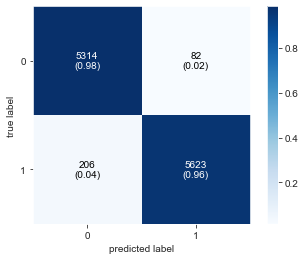

In [60]:
mnb = MultinomialNB()

y_predicted = predict_on_model(mnb, X_train_lemm, y_train_lemm, X_test_lemm)
plot_results(y_test_lemm, y_predicted)

Accuracy: 0.972739420935412


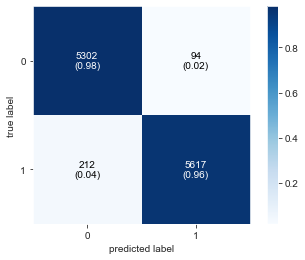

In [61]:
y_predicted = predict_on_model(mnb, X_train_stem, y_train_stem, X_test_stem)
plot_results(y_test_stem, y_predicted)

Accuracy: 0.987260579064588


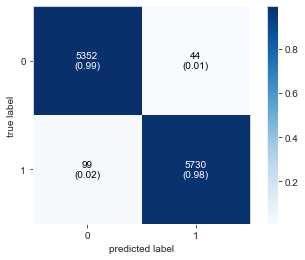

In [62]:
svc = LinearSVC()

y_predicted = predict_on_model(svc, X_train_lemm, y_train_lemm, X_test_lemm)
plot_results(y_test_stem, y_predicted)

Accuracy: 0.9882405345211581


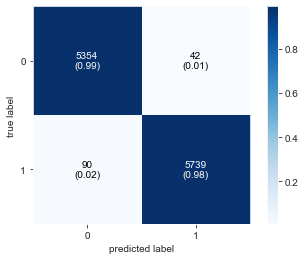

In [63]:
y_predicted = predict_on_model(svc, X_train_stem, y_train_stem, X_test_stem)
plot_results(y_test_stem, y_predicted)

Accuracy: 0.9871714922048997


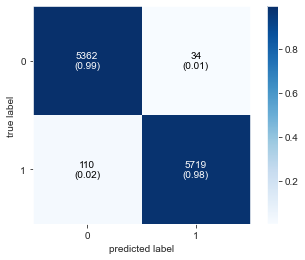

In [64]:
passive_aggressive = PassiveAggressiveClassifier()

y_predicted = predict_on_model(passive_aggressive, X_train_lemm, y_train_lemm, X_test_lemm)
plot_results(y_test_stem, y_predicted)

Accuracy: 0.9878841870824053


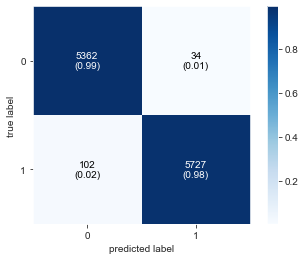

In [65]:
y_predicted = predict_on_model(passive_aggressive, X_train_stem, y_train_stem, X_test_stem)
plot_results(y_test_stem, y_predicted)

As we can see, shallow learning models can get almost 100% accuracy on this
dataset. In SVC and Passive Aggressive lemmatization proved to be slightly
better in terms of performance.

Now, we can move on to deep learning problem-solving, especially using LSTM layers.

In [40]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
voc_size = 10000

X_stem_nn = X_stemmed['text'].apply(lambda x: one_hot(x, voc_size))
X_stem_nn.shape

(44898,)

In [46]:
max_sentence_length = X_stem_nn.map(len).max()
X_stem_nn = pad_sequences(X_stem_nn, padding='pre', maxlen=max_sentence_length)
X_stem_nn[0]

array([   0,    0,    0, ..., 6355, 1677, 4451])

In [66]:
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem_nn, y['label'], test_size=.15,
                                                                        random_state=42)
X_train_stem, X_val_stem, y_train_stem, y_val_stem = train_test_split(X_train_stem, y_train_stem, test_size=.15,
                                                                      random_state=8)
X_train_stem.shape

(32438, 4702)

In [51]:
embedding_vector_features = 50
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=max_sentence_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4702, 50)          500000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 560,501
Trainable params: 560,501
Non-trainable params: 0
_________________________________________________________________


In [53]:
batch_size = 128

model.fit(X_train_stem, y_train_stem, epochs=10, batch_size=batch_size, callbacks=[EarlyStopping(patience=2)],
          validation_data=(X_val_stem, y_val_stem))

Epoch 1/10
254/254 [==============================] - 210s 825ms/step - loss: 0.0618 - accuracy: 0.9820 - val_loss: 0.0577 - val_accuracy: 0.9852

In [67]:
model.evaluate(X_test_stem, y_test_stem)

211/211 [==============================] - 29s 129ms/step - loss: 0.2453 - accuracy: 0.8962

[0.24526947736740112, 0.8962138295173645]